# Haensel 4 Pages report
## By Ahmed Ghandour

This report contains steps done towards solving the Data scientist task

### Folder content
* This folder contains a solution for task using python build using conda environment called h_ams. One you install the environment file using conda it will include all packages required to run this solution.
* You can also run the full solution from the **"main.py"** file.
* This Solution folder called **"helperFunctions"** contains a subfolder contains all functions which I've also created to help build this solution.
* All plots were extracted in the **"visualizations"** folder.
* Data files are stored in the **"data"** folder.
* Report in PDF file, and the Jupyter notebook used to create this report with the name "Haensel_short_report".
* Another PDF report and it's notebook for the out put of the full run with the name "full_run"
* Simple Power BI report.
##### Code Files are:
* *main.py* : the main file to run the full solution.
* *check_merge_data.py*: functions check the data after loading them and merge the 2 csv files.
* *clustering.py*: contains the implementation of KMeans clustering and plotting clusters for visualization.
* *clv.py*: Calculate the Customer Lifetime Value (CLV) using many techniques.
* *cohorts*: Building some cohorts such as time cohorts and behavior cohorts like Monthly Active customers in each cohort, and Retention Rate Cohort.
* *date_time_utils.py*: for dealing with datetimes and ploting insights over time such as the revenue over time.
* *outlier_detection.py*: Get inlier and outlier range using many techniques such as zscore, modified zscore, etc..
* *predict_customer_transaction_for_last_month.py*: a Linear regression model to predict sales for the last month.
* *read_data.py*:  reads the csv data files from the disk.
* *rfmt_ihc.py*: claculate some important metrics such as Recency, Frequency, Monetary Value, and Tenure then compile them with mean value of the IHC per customer per channel.
* *tidy_data.py*: Tidy Data to be observations into rows, and fields into columns as defined by "Hadley Wickham" 
* 2 Jupyter notebook file (*jnb_draft_trials_page1.ipynb*, and *jnb_draft_trials_p2.ipynb*): These are some trials or extra files not included in the solution, as I or tried files keep solution simple, easy, and fast to run only (a playground sketch for me to try some extra lines of code). for example, these files contains Hirarchical clustering which performs customer segmantaion, but I didn't include it as you know that some other algorithms such as KMeans are much faster to run. Thats why I included KMeans in the solution, but also tried hirarchical clustering a side and plot it's dendrogram to get the distance or similarity between cluster. It also contain some extra parts not included in the solution file such as a small ensambling gbm regression model with randomized search over hyperparameters. I also didn't include it, since Linear regression was much much faster to run, simple and provided the same good results which of course I've tried first and kept in the solution.

## Insights:
After reading date, compile them, make them clean and tidy, and perform some EDA. I started to define some metrics such as:

### Revenue Over Time

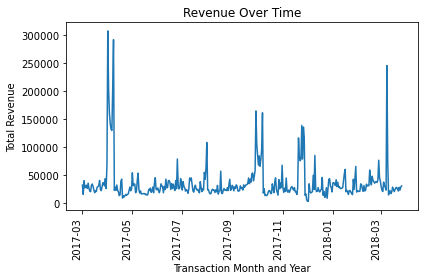

We can notice that revenue is always high between march and april thus we conclude it might be seasonal offers


In [1]:
import pandas as pd
from helperFunctions.date_time_utils import plot_rev_over_time
tidyUserAttr_df = pd.read_csv('data/cleanUserAttr_df.csv').drop('Unnamed: 0', axis=1)
tidyUserAttr_df.Conv_Date = pd.to_datetime(tidyUserAttr_df.Conv_Date)
plot_rev_over_time(df=tidyUserAttr_df, df_gp_by="Conv_Date", df_col="Revenue", df_agg_func="sum",
                   title="Revenue Over Time", xlab="Transaction Month and Year", ylab="Total Revenue",
                   save_f_name="Revenue_Over_Time")
print("We can notice that revenue is always high between march and april thus we conclude it might be seasonal offers")

In [2]:
# Data range and taking snapshot_date

print("\nMin snapshot date:{}; and Max snapshot date:{}".format(min(tidyUserAttr_df.Conv_Date), max(tidyUserAttr_df.Conv_Date)))
print("Data duration is about 13 months")


Min snapshot date:2017-03-01 00:00:00; and Max snapshot date:2018-03-26 00:00:00
Data duration is about 13 months


I also notced that all customers conversed on the same day when they started the session
### Fraction of return customers

In [3]:
# Fraction of return customers
fracReturnCustomers = (tidyUserAttr_df.groupby("User_ID")[
                           "Conv_ID"].nunique() > 1).sum() / tidyUserAttr_df.User_ID.nunique()
print("Fraction of return cutomers is {:.2f} %".format(fracReturnCustomers * 100))

Fraction of return cutomers is 16.12 %


### Cohorts:

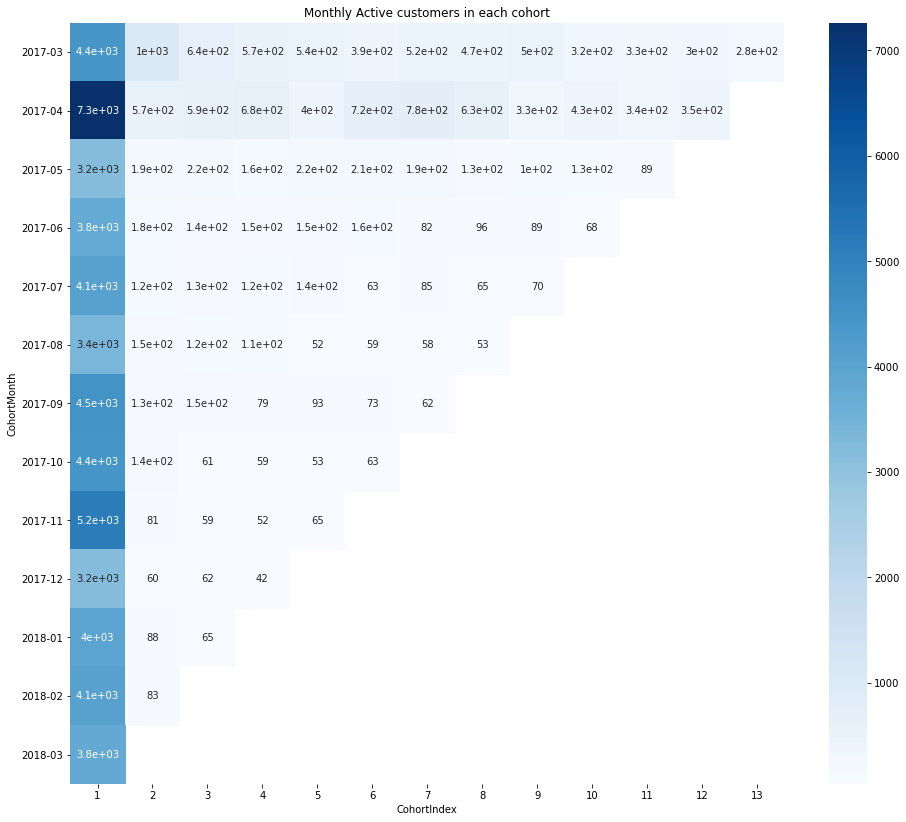

We can notice that the first column contains the total of active cohort customers in each cohort month
We can notice also that April 2017 has the most number of active users and cohort users


In [4]:
from helperFunctions.cohorts import *

tidyUserAttr_df = add_cohort_columns(tidyUserAttr_df, "User_ID")

# Monthly Active customers in each cohort
cohort_counts = build_time_cohort(df=tidyUserAttr_df, df_grp_by=["CohortMonth", "CohortIndex"], cohort_slic="User_ID",
                                  func=pd.Series.nunique)
vis_cohort(cohort_counts, "Monthly Active customers in each cohort", "Monthly_Active_customers_in_each_cohort")

print("We can notice that the first column contains the total of active cohort customers in each cohort month")
print("We can notice also that April 2017 has the most number of active users and cohort users")

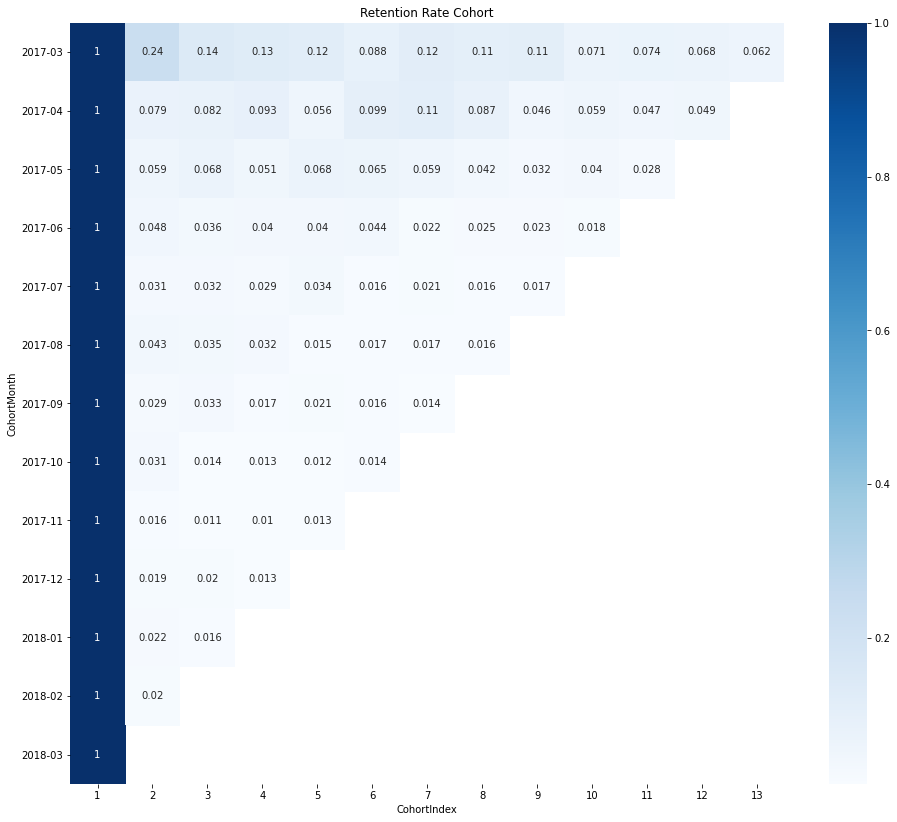

In [5]:
# Retention Rate Cohort
# Get the total cohort sizes or counts from the first column of the cohort_counts
cohort_sizes = cohort_counts.iloc[:, 0]
retention = cohort_counts.divide(cohort_sizes, axis=0)
# Plot the Retention Rate Cohort and exclude the first column of the total for better visualization in the heat map
vis_cohort(retention, "Retention Rate Cohort", "Retention_Rate_Cohort")

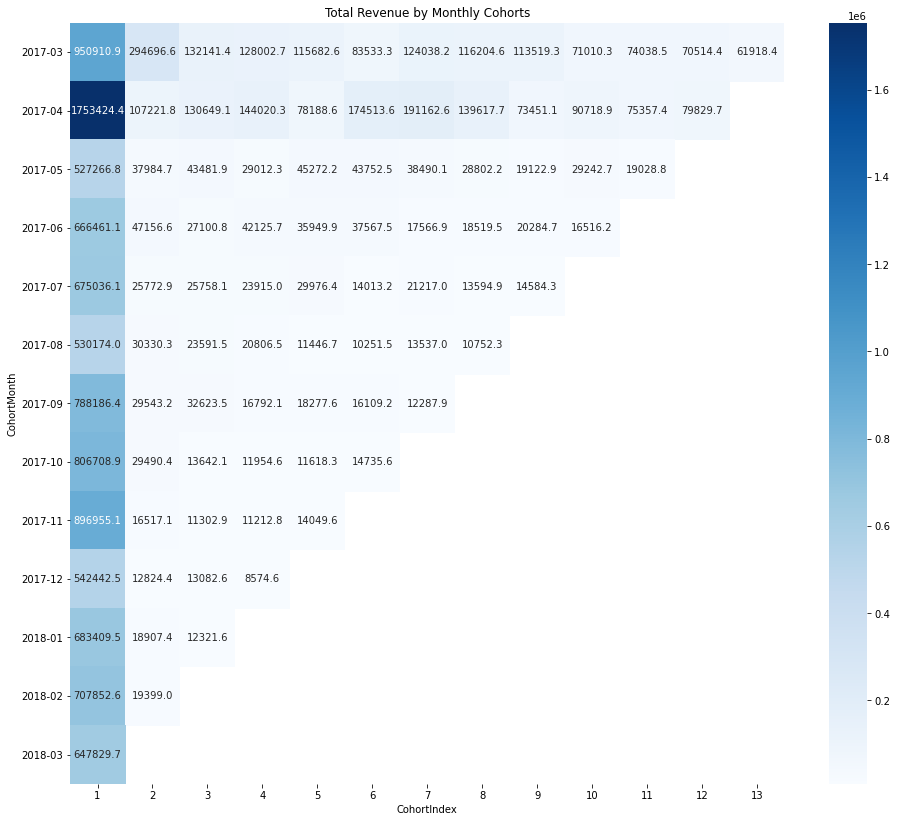

In [6]:
# Calculate total revenue by Monthly Cohorts
rev_counts = build_time_cohort(df=tidyUserAttr_df, df_grp_by=["CohortMonth", "CohortIndex"], cohort_slic="Revenue",
                               func=sum)
vis_cohort(df=rev_counts, plt_title="Total Revenue by Monthly Cohorts", frmt=".1f",
           save_f_name="Total_Revenue_by_Monthly_Cohorts")

### Customer Lifetime Value (CLV)

In [7]:
from helperFunctions.clv import *

# Calculate CLV

# Basic CLV calculation
basic_clv(tidyUserAttr_df, "User_ID", "InvoiceMonth", "Revenue", 36)

# Granular CLV calculation
granular_clv(tidyUserAttr_df, "User_ID", "InvoiceMonth", "Revenue", "Conv_ID", 36)

# Traditional CLV
# # Calculate monthly spend per customer
traditional_clv(tidyUserAttr_df, retention, "User_ID", "InvoiceMonth", "Revenue")


Average basic CLV is 6960.8 $ based on a lifespan of 36 months

Average granular CLV is 6960.8 $ based on a lifespan of 36 months

Average traditional CLV is 10.0 $ at 4.9 % retention_rate


### Predicting last month sales using data from the remaining months only
#### Linear Regression model

In [8]:
# Build Lin reg model to predict total customer traction for the last month
from helperFunctions.predict_customer_transaction_for_last_month import train_model_to_predict_sales

# Train a simple linear regression model to preidct custemer sales for the last month
uniqueChannels = ['A', 'G', 'H', 'I', 'B']
_ = train_model_to_predict_sales(df=tidyUserAttr_df, channels_to_keep=uniqueChannels)

RMSE train: 0.1464754378467411; RMSE test: 0.15721296117534553
MAE train: 0.0392831706098676, MAE test: 0.0397795373372464

Although it's an extremely simple and easy model , it achieved a very good results


Get model coefficients:

Recency         -0.000314
MonetaryValue    0.000110
Tenure           0.000267
A               -0.000924
G               -0.004147
H               -0.002282
I               -0.002848
B                0.002229
dtype: float64


### RFMT IHC Segmantation

I also extracted and built a data frame for RFMT and IHC mean values
* Recency - R - days since last customer transaction
* Frequency - F - number of transactions in the last 13 months (I dropped it later since it didn't add new information. more than 85% of customers come only once, and the remaining are twice only, plus some outliers (loyal customers)
* Monetary Value - M - total spend in the last 13 months
* Tenure - T - time since the first transaction
* IHC means - Initializer, Holder and Closer average values per customer per channel.

Also score can be assigned to it based on many factors such as weights or precentiles using qcut for instance, etc. to perform manual customer clustering or segmantation

### KMeans Clustering

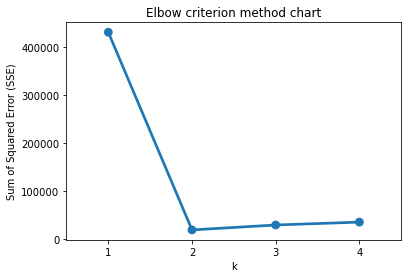

In [9]:
from helperFunctions.clustering import *
rfmtihc_clean = pd.read_csv('data/clean_rmtihc.csv')
rfmtihc_clean.set_index('key_0', inplace=True)
sse, clusters_labels = create_kmeans_clusters(rfmtihc_clean, 5)
plot_clusters(sse)

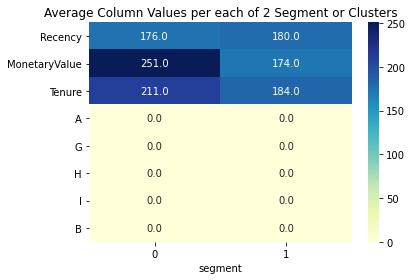

In [10]:
show_clusters_hmap(rfmtihc_clean, clusters_labels, 2)

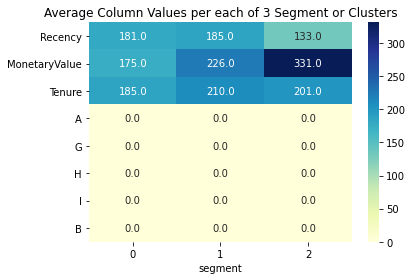

In [11]:
show_clusters_hmap(rfmtihc_clean, clusters_labels, 3)